# WeGo Public Transit
[WeGo Public Transit](https://www.wegotransit.com/) is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. This dataset contains a column HDWY_DEV, which shows the headway deviation. This variable will be negative when bunching has occurred (shorter headway than scheduled) and will be positive for gapping (longer headway than scheduled). Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY.

Goals of this project:
1. How much impact does being late or too spaced out at the first stop have downstream?

2. What is the impact of the layover at the start of the trip (the difference between the first top arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

3. How closely does lateness (ADHERENCE) correlate to headway?

4. What is the relationship between distance or time travelled since the start of a given trip and the headway deviation? Does headway become less statble the further along the route the bus has travelled?

5. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

6. How does direction of travel, route, or location affect the headway and on-time performance?

7. How does time of day or day of week affect headway and on-time performance? Can you detect an impact of school schedule on headway deviation (for certain routes and at certain times of day)?

8. Does weather have any effect on headway or on-time performance? To help answer this question, the file bna_2022.csv contains historical weather data recorded at Nashville International Airport. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wego = pd.read_csv('../data/Headway_Data.csv')
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,15.983333,1.983333,0,0,1,0,0.0,0,2,12.650000
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,17.333333,3.333333,0,0,1,0,0.0,0,11,0.000000
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,NaN,NaN,0,1,0,0,NaN,0,23,22.416666
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,24,5.766666
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,25,0.000000


In [3]:
wego_weather = pd.read_csv('../data/bna_weather.csv')
wego_weather.head()

,Date,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,...,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
0,2021-11-01 00:53:00,KBNA,observation,1635753180,KBNA,Nashville,1635745980,N,51,26,...,OVC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-01 01:30:00,KBNA,observation,1635755400,KBNA,Nashville,1635748200,N,50,29,...,SCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-11-01 01:53:00,KBNA,observation,1635756780,KBNA,Nashville,1635749580,N,49,33,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-11-01 02:53:00,KBNA,observation,1635760380,KBNA,Nashville,1635753180,N,48,33,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-01 03:53:00,KBNA,observation,1635763980,KBNA,Nashville,1635756780,N,47,33,...,CLR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
wego['DEV_PERC'] = wego['HDWY_DEV'] / wego['SCHEDULED_HDWY']
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,DEV_PERC
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,1.983333,0,0,1,0,0.0,0,2,12.650000,0.141667
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,3.333333,0,0,1,0,0.0,0,11,0.000000,0.238095
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,NaN,0,1,0,0,NaN,0,23,22.416666,NaN
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,NaN,0,0,1,0,0.0,0,24,5.766666,NaN
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,NaN,0,0,1,0,NaN,0,25,0.000000,NaN


In [5]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 31 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   CALENDAR_ID                int64  
 1   SERVICE_ABBR               int64  
 2   ADHERENCE_ID               int64  
 3   DATE                       object 
 4   ROUTE_ABBR                 int64  
 5   BLOCK_ABBR                 int64  
 6   OPERATOR                   int64  
 7   TRIP_ID                    int64  
 8   OVERLOAD_ID                int64  
 9   ROUTE_DIRECTION_NAME       object 
 10  TIME_POINT_ABBR            object 
 11  ROUTE_STOP_SEQUENCE        float64
 12  TRIP_EDGE                  int64  
 13  LATITUDE                   float64
 14  LONGITUDE                  float64
 15  SCHEDULED_TIME             object 
 16  ACTUAL_ARRIVAL_TIME        object 
 17  ACTUAL_DEPARTURE_TIME      object 
 18  ADHERENCE                  float64
 19  SCHEDULED_HDWY             float64
 20  AC

In [6]:
wego.isna().sum()

CALENDAR_ID                       0
SERVICE_ABBR                      0
ADHERENCE_ID                      0
DATE                              0
ROUTE_ABBR                        0
BLOCK_ABBR                        0
OPERATOR                          0
TRIP_ID                           0
OVERLOAD_ID                       0
ROUTE_DIRECTION_NAME              0
TIME_POINT_ABBR                   0
ROUTE_STOP_SEQUENCE              41
TRIP_EDGE                         0
LATITUDE                          0
LONGITUDE                         0
SCHEDULED_TIME                    0
ACTUAL_ARRIVAL_TIME           54383
ACTUAL_DEPARTURE_TIME         54430
ADHERENCE                     54430
SCHEDULED_HDWY               432294
ACTUAL_HDWY                  473824
HDWY_DEV                     474368
ADJUSTED_EARLY_COUNT              0
ADJUSTED_LATE_COUNT               0
ADJUSTED_ONTIME_COUNT             0
STOP_CANCELLED                    0
PREV_SCHED_STOP_CANCELLED    402647
IS_RELIEF                   

In [7]:
wego['ROUTE_ABBR'].value_counts()

55    362259
56    355098
52    291150
23    250787
50    249880
3     216446
22    153074
7     103021
Name: ROUTE_ABBR, dtype: int64

In [8]:
wego['BLOCK_ABBR'].value_counts()

2312    50892
2310    49518
300     45464
5004    45164
2311    44900
        ...  
5090       14
5695        8
5694        8
5691        2
5692        2
Name: BLOCK_ABBR, Length: 113, dtype: int64

In [9]:
wego['TRIP_ID'].value_counts()

302998    715
302923    712
305058    704
303006    679
303075    678
         ... 
298941      5
298340      3
298341      3
314754      2
314755      2
Name: TRIP_ID, Length: 18495, dtype: int64

In [10]:
wego['TIME_POINT_ABBR'].value_counts()

GXRVRGAT    88506
DWMRT       83826
WHBG        67522
MXTHOMP     60462
MXWHARF     60447
            ...  
CRES          170
HLHS          137
MCC4_13       131
MCC5_3         85
MCC4_21         5
Name: TIME_POINT_ABBR, Length: 65, dtype: int64

In [11]:
wego_tidy = wego.iloc[:, np.r_[0:22, 29, 30]]
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   CALENDAR_ID            int64  
 1   SERVICE_ABBR           int64  
 2   ADHERENCE_ID           int64  
 3   DATE                   object 
 4   ROUTE_ABBR             int64  
 5   BLOCK_ABBR             int64  
 6   OPERATOR               int64  
 7   TRIP_ID                int64  
 8   OVERLOAD_ID            int64  
 9   ROUTE_DIRECTION_NAME   object 
 10  TIME_POINT_ABBR        object 
 11  ROUTE_STOP_SEQUENCE    float64
 12  TRIP_EDGE              int64  
 13  LATITUDE               float64
 14  LONGITUDE              float64
 15  SCHEDULED_TIME         object 
 16  ACTUAL_ARRIVAL_TIME    object 
 17  ACTUAL_DEPARTURE_TIME  object 
 18  ADHERENCE              float64
 19  SCHEDULED_HDWY         float64
 20  ACTUAL_HDWY            float64
 21  HDWY_DEV               float64
 22  DWELL_IN_MINS     

In [12]:
wego_tidy = wego_tidy.rename(columns = {'DEV_PERC':'HDWY_DEV_PERC'})
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   CALENDAR_ID            int64  
 1   SERVICE_ABBR           int64  
 2   ADHERENCE_ID           int64  
 3   DATE                   object 
 4   ROUTE_ABBR             int64  
 5   BLOCK_ABBR             int64  
 6   OPERATOR               int64  
 7   TRIP_ID                int64  
 8   OVERLOAD_ID            int64  
 9   ROUTE_DIRECTION_NAME   object 
 10  TIME_POINT_ABBR        object 
 11  ROUTE_STOP_SEQUENCE    float64
 12  TRIP_EDGE              int64  
 13  LATITUDE               float64
 14  LONGITUDE              float64
 15  SCHEDULED_TIME         object 
 16  ACTUAL_ARRIVAL_TIME    object 
 17  ACTUAL_DEPARTURE_TIME  object 
 18  ADHERENCE              float64
 19  SCHEDULED_HDWY         float64
 20  ACTUAL_HDWY            float64
 21  HDWY_DEV               float64
 22  DWELL_IN_MINS     

In [13]:
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,HDWY_DEV_PERC
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,-86.812719,14:10:00,13:59:21,14:12:00,-2.000000,14.0,15.983333,1.983333,12.650000,0.141667
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,-86.800622,14:20:00,14:23:21,14:23:21,-3.350000,14.0,17.333333,3.333333,0.000000,0.238095
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,-86.781923,14:39:00,14:36:46,14:59:11,-20.183333,NaN,NaN,NaN,22.416666,NaN
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,-86.800851,15:10:00,15:04:31,15:10:17,-0.283333,NaN,NaN,NaN,5.766666,NaN
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,-86.781923,15:27:00,15:16:59,15:16:59,10.016666,NaN,NaN,NaN,0.000000,NaN


In [14]:
wego['ROUTE_STOP_SEQUENCE'].value_counts()

5.0     278419
4.0     214527
8.0     181918
3.0     177798
2.0     157335
10.0    154766
6.0     153988
9.0     141764
7.0     102499
11.0     99828
12.0     73821
13.0     63406
14.0     52909
15.0     46339
1.0      32748
17.0     24805
16.0     24804
Name: ROUTE_STOP_SEQUENCE, dtype: int64

In [15]:
wego_tidy.groupby('ROUTE_STOP_SEQUENCE', as_index=False)['ROUTE_ABBR'].value_counts()

,ROUTE_STOP_SEQUENCE,ROUTE_ABBR,count
0,1.0,22,29045
1,1.0,23,2445
2,1.0,55,245
3,1.0,50,217
4,1.0,52,213
...,...,...,...
84,14.0,22,11592
85,15.0,50,39395
86,15.0,22,6944
87,16.0,50,24804


In [16]:
wego_tidy.groupby('ROUTE_ABBR', as_index=False)['HDWY_DEV_PERC'].mean()

,ROUTE_ABBR,HDWY_DEV_PERC
0,3,0.029075
1,7,0.022715
2,22,0.030718
3,23,0.023105
4,50,NaN
5,52,0.022999
6,55,NaN
7,56,NaN


In [17]:
wego_tidy.groupby('ROUTE_STOP_SEQUENCE', as_index=False)['HDWY_DEV_PERC'].mean()

,ROUTE_STOP_SEQUENCE,HDWY_DEV_PERC
0,1.0,0.013355
1,2.0,0.015778
2,3.0,0.027638
3,4.0,0.021843
4,5.0,0.020038
5,6.0,NaN
6,7.0,NaN
7,8.0,0.014616
8,9.0,0.025739
9,10.0,NaN


In [18]:
wego_tidy.isna().sum()

CALENDAR_ID                   0
SERVICE_ABBR                  0
ADHERENCE_ID                  0
DATE                          0
ROUTE_ABBR                    0
BLOCK_ABBR                    0
OPERATOR                      0
TRIP_ID                       0
OVERLOAD_ID                   0
ROUTE_DIRECTION_NAME          0
TIME_POINT_ABBR               0
ROUTE_STOP_SEQUENCE          41
TRIP_EDGE                     0
LATITUDE                      0
LONGITUDE                     0
SCHEDULED_TIME                0
ACTUAL_ARRIVAL_TIME       54383
ACTUAL_DEPARTURE_TIME     54430
ADHERENCE                 54430
SCHEDULED_HDWY           432294
ACTUAL_HDWY              473824
HDWY_DEV                 474368
DWELL_IN_MINS             54456
HDWY_DEV_PERC            474368
dtype: int64

In [19]:
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   CALENDAR_ID            int64  
 1   SERVICE_ABBR           int64  
 2   ADHERENCE_ID           int64  
 3   DATE                   object 
 4   ROUTE_ABBR             int64  
 5   BLOCK_ABBR             int64  
 6   OPERATOR               int64  
 7   TRIP_ID                int64  
 8   OVERLOAD_ID            int64  
 9   ROUTE_DIRECTION_NAME   object 
 10  TIME_POINT_ABBR        object 
 11  ROUTE_STOP_SEQUENCE    float64
 12  TRIP_EDGE              int64  
 13  LATITUDE               float64
 14  LONGITUDE              float64
 15  SCHEDULED_TIME         object 
 16  ACTUAL_ARRIVAL_TIME    object 
 17  ACTUAL_DEPARTURE_TIME  object 
 18  ADHERENCE              float64
 19  SCHEDULED_HDWY         float64
 20  ACTUAL_HDWY            float64
 21  HDWY_DEV               float64
 22  DWELL_IN_MINS     

In [20]:
wego_tidy.groupby(['ROUTE_ABBR', 'TRIP_EDGE']).agg({'HDWY_DEV':['mean']})

HDWY_DEV
                          mean
ROUTE_ABBR TRIP_EDGE          
3          0          0.401955
           1          1.783789
           2               NaN
7          0          0.423648
           1          0.458352
           2               NaN
22         0          0.835121
           1          0.686182
           2               NaN
23         0          0.320139
           1          0.281098
           2               NaN
50         0          0.343754
           1          0.253160
           2               NaN
52         0          0.383679
           1          0.564645
           2               NaN
55         0          0.129438
           1          0.215000
           2               NaN
56         0          0.263420
           1          0.154020
           2               NaN

In [21]:
dev_and_adherence = wego_tidy.groupby('ROUTE_STOP_SEQUENCE', as_index=False)['HDWY_DEV', 'ADHERENCE'].mean()
dev_and_adherence.corr()

/var/folders/46/zm0dtt4s22d760_6ml4_t_vr0000gn/T/ipykernel_85306/1211782545.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dev_and_adherence = wego_tidy.groupby('ROUTE_STOP_SEQUENCE', as_index=False)['HDWY_DEV', 'ADHERENCE'].mean()


,ROUTE_STOP_SEQUENCE,HDWY_DEV,ADHERENCE
ROUTE_STOP_SEQUENCE,1.000000,-0.230019,-0.43927
HDWY_DEV,-0.230019,1.000000,-0.36588
ADHERENCE,-0.439270,-0.365880,1.00000


In [22]:
wego_tidy.groupby(['TRIP_ID', 'TRIP_EDGE']).agg({'ADHERENCE':['mean']})

ADHERENCE
                        mean
TRIP_ID TRIP_EDGE           
297749  1          -1.205556
        2           7.748611
297750  0          -2.034722
        1          -2.611111
        2         -12.241666
...                      ...
329980  2          -7.153703
330003  1          11.475926
        2         -48.166667
330011  1          -2.548148
        2          -4.516666

[55414 rows x 1 columns]

In [23]:
wego_tidy['ADHERENCE'].describe()

count    1.927285e+06
mean    -2.193849e+00
std      4.886912e+00
min     -5.067667e+02
25%     -3.400000e+00
50%     -1.383333e+00
75%     -1.333330e-01
max      7.883333e+01
Name: ADHERENCE, dtype: float64

In [24]:
wego_tidy['ADHERENCE_CAT'] = ''

for ind, row in wego_tidy.iterrows():
    if row['ADHERENCE'] < -3.4:
        wego_tidy.loc[ind, 'ADHERENCE_CAT'] = 'SLOWEST 25%'
    elif row['ADHERENCE'] < -1.383:
        wego_tidy.loc[ind, 'ADHERENCE_CAT'] = '25 to 50%'
    elif row['ADHERENCE'] < -1.33333:
        wego_tidy.loc[ind, 'ADHERENCE_CAT'] = '50 to 75%'
    else:
        wego_tidy.loc[ind, 'ADHERENCE_CAT'] = 'FASTEST 25%'
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,HDWY_DEV_PERC,ADHERENCE_CAT
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:10:00,13:59:21,14:12:00,-2.000000,14.0,15.983333,1.983333,12.650000,0.141667,25 to 50%
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:20:00,14:23:21,14:23:21,-3.350000,14.0,17.333333,3.333333,0.000000,0.238095,25 to 50%
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:39:00,14:36:46,14:59:11,-20.183333,NaN,NaN,NaN,22.416666,NaN,SLOWEST 25%
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:10:00,15:04:31,15:10:17,-0.283333,NaN,NaN,NaN,5.766666,NaN,FASTEST 25%
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:27:00,15:16:59,15:16:59,10.016666,NaN,NaN,NaN,0.000000,NaN,FASTEST 25%


In [25]:
wego_tidy.groupby(['ADHERENCE_CAT', 'TRIP_EDGE']).agg({'ADHERENCE':['mean']})

ADHERENCE
                             mean
ADHERENCE_CAT TRIP_EDGE          
25 to 50%     0         -2.282941
              1         -2.236970
              2         -2.310418
50 to 75%     0         -1.349862
              1         -1.350131
              2         -1.349640
FASTEST 25%   0         -0.162620
              1          0.085776
              2          2.149950
SLOWEST 25%   0         -7.442101
              1         -5.994766
              2         -8.949721

In [26]:
wego_tidy.groupby(['TRIP_ID', 'TRIP_EDGE']).agg({'ADHERENCE':['mean']})

ADHERENCE
                        mean
TRIP_ID TRIP_EDGE           
297749  1          -1.205556
        2           7.748611
297750  0          -2.034722
        1          -2.611111
        2         -12.241666
...                      ...
329980  2          -7.153703
330003  1          11.475926
        2         -48.166667
330011  1          -2.548148
        2          -4.516666

[55414 rows x 1 columns]

In [27]:
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   CALENDAR_ID            int64  
 1   SERVICE_ABBR           int64  
 2   ADHERENCE_ID           int64  
 3   DATE                   object 
 4   ROUTE_ABBR             int64  
 5   BLOCK_ABBR             int64  
 6   OPERATOR               int64  
 7   TRIP_ID                int64  
 8   OVERLOAD_ID            int64  
 9   ROUTE_DIRECTION_NAME   object 
 10  TIME_POINT_ABBR        object 
 11  ROUTE_STOP_SEQUENCE    float64
 12  TRIP_EDGE              int64  
 13  LATITUDE               float64
 14  LONGITUDE              float64
 15  SCHEDULED_TIME         object 
 16  ACTUAL_ARRIVAL_TIME    object 
 17  ACTUAL_DEPARTURE_TIME  object 
 18  ADHERENCE              float64
 19  SCHEDULED_HDWY         float64
 20  ACTUAL_HDWY            float64
 21  HDWY_DEV               float64
 22  DWELL_IN_MINS     

In [28]:
corr_df = wego_tidy[['ADHERENCE', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'HDWY_DEV_PERC', 'DWELL_IN_MINS']]
corr_df.head()

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_DEV_PERC,DWELL_IN_MINS
0,-2.000000,14.0,15.983333,1.983333,0.141667,12.650000
1,-3.350000,14.0,17.333333,3.333333,0.238095,0.000000
2,-20.183333,NaN,NaN,NaN,NaN,22.416666
3,-0.283333,NaN,NaN,NaN,NaN,5.766666
4,10.016666,NaN,NaN,NaN,NaN,0.000000


In [29]:
corr_df.corr()

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,HDWY_DEV_PERC,DWELL_IN_MINS
ADHERENCE,1.000000,0.029726,-0.086441,-0.237548,-0.252127,-0.029330
SCHEDULED_HDWY,0.029726,1.000000,0.879361,0.024768,-0.003067,0.074162
ACTUAL_HDWY,-0.086441,0.879361,1.000000,0.497789,0.409670,0.076534
HDWY_DEV,-0.237548,0.024768,0.497789,1.000000,0.866175,0.027235
HDWY_DEV_PERC,-0.252127,-0.003067,0.409670,0.866175,1.000000,0.020617
DWELL_IN_MINS,-0.029330,0.074162,0.076534,0.027235,0.020617,1.000000


/var/folders/46/zm0dtt4s22d760_6ml4_t_vr0000gn/T/ipykernel_85306/3147104518.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


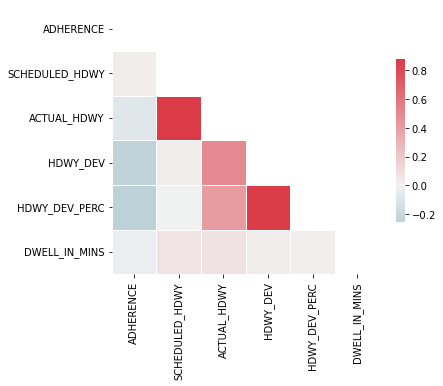

In [30]:
plt.figure(figsize=(6, 6))

corr = corr_df.corr()

# create a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [31]:
import calendar
from datetime import date
from datetime import datetime

In [32]:
wego_tidy['DATE'] =  pd.to_datetime(wego_tidy['DATE'])
wego_tidy['WEEKDAY'] = [calendar.day_name[x.weekday()] for x in wego_tidy['DATE']]
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,HDWY_DEV_PERC,ADHERENCE_CAT,WEEKDAY
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,13:59:21,14:12:00,-2.000000,14.0,15.983333,1.983333,12.650000,0.141667,25 to 50%,Monday
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:23:21,14:23:21,-3.350000,14.0,17.333333,3.333333,0.000000,0.238095,25 to 50%,Monday
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:36:46,14:59:11,-20.183333,NaN,NaN,NaN,22.416666,NaN,SLOWEST 25%,Monday
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:04:31,15:10:17,-0.283333,NaN,NaN,NaN,5.766666,NaN,FASTEST 25%,Monday
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:16:59,15:16:59,10.016666,NaN,NaN,NaN,0.000000,NaN,FASTEST 25%,Monday


In [33]:
wego_tidy['HDWY_DEV'].describe()

count    1.507347e+06
mean     3.647395e-01
std      6.579797e+00
min     -2.220667e+02
25%     -1.883334e+00
50%      0.000000e+00
75%      1.966666e+00
max      1.054617e+03
Name: HDWY_DEV, dtype: float64

In [34]:
wego_tidy['HDWY_DEV_CAT'] = ''

for ind, row in wego_tidy.iterrows():
    if row['HDWY_DEV'] < -1.883334:
        wego_tidy.loc[ind, 'HDWY_DEV_CAT'] = 'LOWEST 25%'
    elif row['HDWY_DEV'] < 0:
        wego_tidy.loc[ind, 'HDWY_DEV_CAT'] = '25 to 50%'
    elif row['HDWY_DEV'] < 1.966666:
        wego_tidy.loc[ind, 'HDWY_DEV_CAT'] = '50 to 75%'
    else:
        wego_tidy.loc[ind, 'HDWY_DEV_CAT'] = 'HIGHEST 25%'
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,HDWY_DEV_PERC,ADHERENCE_CAT,WEEKDAY,HDWY_DEV_CAT
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:12:00,-2.000000,14.0,15.983333,1.983333,12.650000,0.141667,25 to 50%,Monday,HIGHEST 25%
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:23:21,-3.350000,14.0,17.333333,3.333333,0.000000,0.238095,25 to 50%,Monday,HIGHEST 25%
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:59:11,-20.183333,NaN,NaN,NaN,22.416666,NaN,SLOWEST 25%,Monday,HIGHEST 25%
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:10:17,-0.283333,NaN,NaN,NaN,5.766666,NaN,FASTEST 25%,Monday,HIGHEST 25%
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:16:59,10.016666,NaN,NaN,NaN,0.000000,NaN,FASTEST 25%,Monday,HIGHEST 25%


In [35]:
wego_tidy.groupby(['HDWY_DEV_CAT', 'TRIP_EDGE']).agg({'HDWY_DEV':['mean']})

HDWY_DEV
                            mean
HDWY_DEV_CAT TRIP_EDGE          
25 to 50%    0         -0.850553
             1         -0.842146
50 to 75%    0          0.890649
             1          0.850245
HIGHEST 25%  0          6.125628
             1          6.594230
             2               NaN
LOWEST 25%   0         -4.914932
             1         -4.509360

In [36]:
wego_tidy['DATE'].value_counts()

2022-10-26    6540
2022-11-01    6498
2022-05-02    6491
2022-04-06    6489
2022-10-06    6488
              ... 
2022-01-16    2994
2021-11-25    2993
2021-12-24    2990
2022-03-27    2989
2021-12-26    2987
Name: DATE, Length: 366, dtype: int64

# 2. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more layover lead to more stable headways (lower values for % headway deviation)?

In [37]:
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,DWELL_IN_MINS,HDWY_DEV_PERC,ADHERENCE_CAT,WEEKDAY,HDWY_DEV_CAT
0,120211101,1,76447164,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:12:00,-2.000000,14.0,15.983333,1.983333,12.650000,0.141667,25 to 50%,Monday,HIGHEST 25%
1,120211101,1,76447165,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:23:21,-3.350000,14.0,17.333333,3.333333,0.000000,0.238095,25 to 50%,Monday,HIGHEST 25%
2,120211101,1,76447166,2021-11-01,7,1704,2088,297750,0,TO DOWNTOWN,...,14:59:11,-20.183333,NaN,NaN,NaN,22.416666,NaN,SLOWEST 25%,Monday,HIGHEST 25%
3,120211101,1,76447167,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:10:17,-0.283333,NaN,NaN,NaN,5.766666,NaN,FASTEST 25%,Monday,HIGHEST 25%
4,120211101,1,76447168,2021-11-01,50,1704,2088,297749,0,TO DOWNTOWN,...,15:16:59,10.016666,NaN,NaN,NaN,0.000000,NaN,FASTEST 25%,Monday,HIGHEST 25%


In [39]:
wego_tidy.groupby(['TRIP_ID','TRIP_EDGE']).agg({'DWELL_IN_MINS':['mean']})

DWELL_IN_MINS
                           mean
TRIP_ID TRIP_EDGE              
297749  1             10.797222
        2              0.000000
297750  0              0.000000
        1             10.002777
        2             13.005555
...                         ...
329980  2              1.822222
330003  1             10.912963
        2              1.190476
330011  1             12.866666
        2              1.687037

[55414 rows x 1 columns]

In [41]:
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 27 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   CALENDAR_ID            int64         
 1   SERVICE_ABBR           int64         
 2   ADHERENCE_ID           int64         
 3   DATE                   datetime64[ns]
 4   ROUTE_ABBR             int64         
 5   BLOCK_ABBR             int64         
 6   OPERATOR               int64         
 7   TRIP_ID                int64         
 8   OVERLOAD_ID            int64         
 9   ROUTE_DIRECTION_NAME   object        
 10  TIME_POINT_ABBR        object        
 11  ROUTE_STOP_SEQUENCE    float64       
 12  TRIP_EDGE              int64         
 13  LATITUDE               float64       
 14  LONGITUDE              float64       
 15  SCHEDULED_TIME         object        
 16  ACTUAL_ARRIVAL_TIME    object        
 17  ACTUAL_DEPARTURE_TIME  object        
 18  ADHERENCE             

In [ ]:
wego_tidy = wego_tidy[wego_tidy.columns[[0,1,2,3,25,4,5,6,7,8,9,10,11,12,13,14,15,16,17,22,18,19,20,21,23,24,26]]]
wego_tidy.info()
wego_tidy = wego_tidy[wego_tidy.columns[[0,1,2,3,6,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,4,23,24,25,26]]]
wego_tidy.info()

In [51]:
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,ADHERENCE_CAT,WEEKDAY,BLOCK_ABBR,OPERATOR,TRIP_ID,...,SCHEDULED_TIME,ADHERENCE,ACTUAL_ARRIVAL_TIME,ACTUAL_HDWY,ACTUAL_DEPARTURE_TIME,HDWY_DEV_PERC,DWELL_IN_MINS,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_CAT
0,120211101,1,76447164,2021-11-01,7,25 to 50%,Monday,1704,2088,297750,...,14:10:00,-2.000000,13:59:21,15.983333,14:12:00,0.141667,12.650000,14.0,1.983333,HIGHEST 25%
1,120211101,1,76447165,2021-11-01,7,25 to 50%,Monday,1704,2088,297750,...,14:20:00,-3.350000,14:23:21,17.333333,14:23:21,0.238095,0.000000,14.0,3.333333,HIGHEST 25%
2,120211101,1,76447166,2021-11-01,7,SLOWEST 25%,Monday,1704,2088,297750,...,14:39:00,-20.183333,14:36:46,NaN,14:59:11,NaN,22.416666,NaN,NaN,HIGHEST 25%
3,120211101,1,76447167,2021-11-01,50,FASTEST 25%,Monday,1704,2088,297749,...,15:10:00,-0.283333,15:04:31,NaN,15:10:17,NaN,5.766666,NaN,NaN,HIGHEST 25%
4,120211101,1,76447168,2021-11-01,50,FASTEST 25%,Monday,1704,2088,297749,...,15:27:00,10.016666,15:16:59,NaN,15:16:59,NaN,0.000000,NaN,NaN,HIGHEST 25%


In [52]:
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 27 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   CALENDAR_ID            int64         
 1   SERVICE_ABBR           int64         
 2   ADHERENCE_ID           int64         
 3   DATE                   datetime64[ns]
 4   ROUTE_ABBR             int64         
 5   ADHERENCE_CAT          object        
 6   WEEKDAY                object        
 7   BLOCK_ABBR             int64         
 8   OPERATOR               int64         
 9   TRIP_ID                int64         
 10  OVERLOAD_ID            int64         
 11  ROUTE_DIRECTION_NAME   object        
 12  TIME_POINT_ABBR        object        
 13  ROUTE_STOP_SEQUENCE    float64       
 14  TRIP_EDGE              int64         
 15  LATITUDE               float64       
 16  LONGITUDE              float64       
 17  SCHEDULED_TIME         object        
 18  ADHERENCE             

In [55]:
wego_tidy = wego_tidy[wego_tidy.columns[[0,1,2,3,6,4,7,8,9,10,11,12,13,14,15,16,17,18,5,19,21,23,20,24,25,22,26]]]

In [56]:
wego_tidy.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,WEEKDAY,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,...,ADHERENCE,ADHERENCE_CAT,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC,HDWY_DEV_CAT
0,120211101,1,76447164,2021-11-01,Monday,7,1704,2088,297750,0,...,-2.000000,25 to 50%,13:59:21,14:12:00,12.650000,15.983333,14.0,1.983333,0.141667,HIGHEST 25%
1,120211101,1,76447165,2021-11-01,Monday,7,1704,2088,297750,0,...,-3.350000,25 to 50%,14:23:21,14:23:21,0.000000,17.333333,14.0,3.333333,0.238095,HIGHEST 25%
2,120211101,1,76447166,2021-11-01,Monday,7,1704,2088,297750,0,...,-20.183333,SLOWEST 25%,14:36:46,14:59:11,22.416666,NaN,NaN,NaN,NaN,HIGHEST 25%
3,120211101,1,76447167,2021-11-01,Monday,50,1704,2088,297749,0,...,-0.283333,FASTEST 25%,15:04:31,15:10:17,5.766666,NaN,NaN,NaN,NaN,HIGHEST 25%
4,120211101,1,76447168,2021-11-01,Monday,50,1704,2088,297749,0,...,10.016666,FASTEST 25%,15:16:59,15:16:59,0.000000,NaN,NaN,NaN,NaN,HIGHEST 25%


In [57]:
wego_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 27 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   CALENDAR_ID            int64         
 1   SERVICE_ABBR           int64         
 2   ADHERENCE_ID           int64         
 3   DATE                   datetime64[ns]
 4   WEEKDAY                object        
 5   ROUTE_ABBR             int64         
 6   BLOCK_ABBR             int64         
 7   OPERATOR               int64         
 8   TRIP_ID                int64         
 9   OVERLOAD_ID            int64         
 10  ROUTE_DIRECTION_NAME   object        
 11  TIME_POINT_ABBR        object        
 12  ROUTE_STOP_SEQUENCE    float64       
 13  TRIP_EDGE              int64         
 14  LATITUDE               float64       
 15  LONGITUDE              float64       
 16  SCHEDULED_TIME         object        
 17  ADHERENCE              float64       
 18  ADHERENCE_CAT         

In [88]:
wego_layover = wego_tidy[wego_tidy.columns[[5,13,21,17,22,23,24,25]]]
wego_layover

,ROUTE_ABBR,TRIP_EDGE,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
0,7,1,12.650000,-2.000000,15.983333,14.0,1.983333,0.141667
1,7,0,0.000000,-3.350000,17.333333,14.0,3.333333,0.238095
2,7,2,22.416666,-20.183333,NaN,NaN,NaN,NaN
3,50,1,5.766666,-0.283333,NaN,NaN,NaN,NaN
4,50,2,0.000000,10.016666,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1981710,50,2,1.016666,-2.733333,NaN,NaN,NaN,NaN
1981711,50,1,9.900000,12.900000,7.633333,10.0,-2.366667,-0.236667
1981712,50,2,0.000000,26.733333,NaN,NaN,NaN,NaN
1981713,56,1,19.366666,0.966666,NaN,0.0,NaN,NaN


In [89]:
wego_layover_stop1 = wego_layover.loc[(wego_layover['TRIP_EDGE'] == 1)]
wego_layover_stop1

,ROUTE_ABBR,TRIP_EDGE,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
0,7,1,12.650000,-2.000000,15.983333,14.0,1.983333,0.141667
3,50,1,5.766666,-0.283333,NaN,NaN,NaN,NaN
5,22,1,12.333333,0.166666,NaN,NaN,NaN,NaN
9,22,1,11.383333,-1.816666,NaN,NaN,NaN,NaN
12,22,1,9.400000,-1.050000,34.633333,35.0,-0.366667,-0.010476
...,...,...,...,...,...,...,...,...
1981705,50,1,9.166666,-3.900000,NaN,NaN,NaN,NaN
1981707,55,1,31.933333,0.800000,NaN,0.0,NaN,NaN
1981709,50,1,20.916666,-2.600000,NaN,NaN,NaN,NaN
1981711,50,1,9.900000,12.900000,7.633333,10.0,-2.366667,-0.236667


In [90]:
wego_layover_stop1_drop = wego_layover_stop1.drop(columns=['TRIP_EDGE'])
wego_layover_stop1_drop.corr()

,ROUTE_ABBR,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
ROUTE_ABBR,1.000000,0.140130,-0.021123,-0.294192,-0.316463,-0.047761,-0.030216
DWELL_IN_MINS,0.140130,1.000000,-0.182863,0.044533,0.012848,0.070651,0.086248
ADHERENCE,-0.021123,-0.182863,1.000000,-0.094517,0.019274,-0.238281,-0.257597
ACTUAL_HDWY,-0.294192,0.044533,-0.094517,1.000000,0.883925,0.511548,0.413590
SCHEDULED_HDWY,-0.316463,0.012848,0.019274,0.883925,1.000000,0.050358,0.009528
HDWY_DEV,-0.047761,0.070651,-0.238281,0.511548,0.050358,1.000000,0.867831
HDWY_DEV_PERC,-0.030216,0.086248,-0.257597,0.413590,0.009528,0.867831,1.000000


/var/folders/46/zm0dtt4s22d760_6ml4_t_vr0000gn/T/ipykernel_85306/3704688314.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


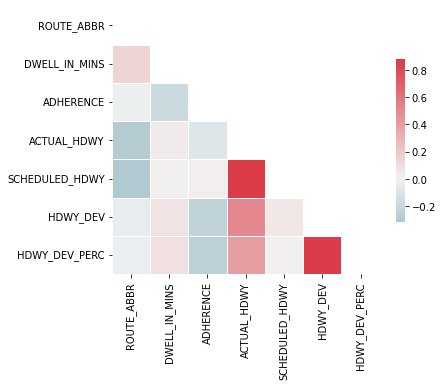

In [91]:
plt.figure(figsize=(6, 6))

corr = wego_layover_stop1_drop.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [92]:
wego_layover_stop0 = wego_layover.loc[(wego_layover['TRIP_EDGE'] == 0)]
wego_layover_stop0_drop = wego_layover_stop0.drop(columns=['TRIP_EDGE'])
wego_layover_stop0_drop.corr()

,ROUTE_ABBR,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
ROUTE_ABBR,1.000000,0.080750,-0.048496,-0.212169,-0.240363,-0.012062,-0.006668
DWELL_IN_MINS,0.080750,1.000000,0.023874,-0.024333,-0.025985,-0.007687,-0.008185
ADHERENCE,-0.048496,0.023874,1.000000,-0.094768,0.022620,-0.240486,-0.252418
ACTUAL_HDWY,-0.212169,-0.024333,-0.094768,1.000000,0.876585,0.494701,0.412591
SCHEDULED_HDWY,-0.240363,-0.025985,0.022620,0.876585,1.000000,0.015412,-0.006689
HDWY_DEV,-0.012062,-0.007687,-0.240486,0.494701,0.015412,1.000000,0.869302
HDWY_DEV_PERC,-0.006668,-0.008185,-0.252418,0.412591,-0.006689,0.869302,1.000000


/var/folders/46/zm0dtt4s22d760_6ml4_t_vr0000gn/T/ipykernel_85306/1664760205.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


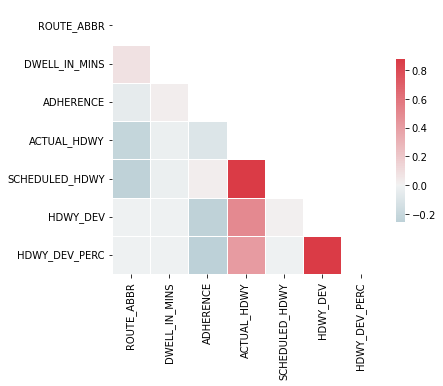

In [93]:
plt.figure(figsize=(6, 6))

corr = wego_layover_stop0_drop.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [94]:
wego_layover_stop2 = wego_layover.loc[(wego_layover['TRIP_EDGE'] == 2)]
wego_layover_stop2_drop = wego_layover_stop2.drop(columns=['TRIP_EDGE'])
wego_layover_stop2_drop.corr()

,ROUTE_ABBR,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
ROUTE_ABBR,1.000000,0.022026,-0.034678,NaN,-0.344970,NaN,NaN
DWELL_IN_MINS,0.022026,1.000000,-0.263417,NaN,0.117267,NaN,NaN
ADHERENCE,-0.034678,-0.263417,1.000000,NaN,0.106867,NaN,NaN
ACTUAL_HDWY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCHEDULED_HDWY,-0.344970,0.117267,0.106867,NaN,1.000000,NaN,NaN
HDWY_DEV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HDWY_DEV_PERC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
wego_layover.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981715 entries, 0 to 1981714
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ROUTE_ABBR      int64  
 1   TRIP_EDGE       int64  
 2   DWELL_IN_MINS   float64
 3   ADHERENCE       float64
 4   ACTUAL_HDWY     float64
 5   SCHEDULED_HDWY  float64
 6   HDWY_DEV        float64
 7   HDWY_DEV_PERC   float64
dtypes: float64(6), int64(2)
memory usage: 121.0 MB


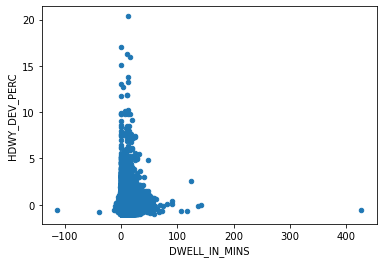

In [96]:
wego_layover_stop1.plot.scatter('DWELL_IN_MINS', 'HDWY_DEV_PERC')
plt.show()

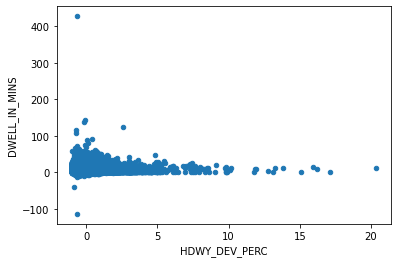

In [97]:
wego_layover_stop1.plot.scatter('HDWY_DEV_PERC', 'DWELL_IN_MINS')
plt.show()

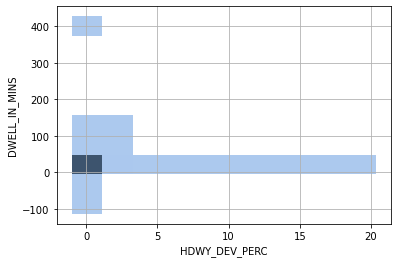

In [98]:
sns.histplot(data = wego_layover_stop1, x='HDWY_DEV_PERC',
             y='DWELL_IN_MINS', kde=True, bins=10)
plt.grid();

In [99]:
wego_layover.head()

,ROUTE_ABBR,TRIP_EDGE,DWELL_IN_MINS,ADHERENCE,ACTUAL_HDWY,SCHEDULED_HDWY,HDWY_DEV,HDWY_DEV_PERC
0,7,1,12.650000,-2.000000,15.983333,14.0,1.983333,0.141667
1,7,0,0.000000,-3.350000,17.333333,14.0,3.333333,0.238095
2,7,2,22.416666,-20.183333,NaN,NaN,NaN,NaN
3,50,1,5.766666,-0.283333,NaN,NaN,NaN,NaN
4,50,2,0.000000,10.016666,NaN,NaN,NaN,NaN


In [102]:
wego_layover.groupby(['ROUTE_ABBR','TRIP_EDGE']).agg({'DWELL_IN_MINS':['mean'], 'HDWY_DEV_PERC':['mean']})

DWELL_IN_MINS HDWY_DEV_PERC
                              mean          mean
ROUTE_ABBR TRIP_EDGE                            
3          0              0.216281      0.019176
           1             12.126302      0.064113
           2              0.147601           NaN
7          0              0.210850      0.020822
           1             12.101802      0.024623
           2              0.100485           NaN
22         0              0.101957      0.039060
           1              9.961609      0.019339
           2              0.060349           NaN
23         0              0.865238      0.025311
           1             11.496666      0.017489
           2              0.120054           NaN
50         0              0.375450      0.017958
           1             14.135486           NaN
           2              0.205019           NaN
52         0              0.942129      0.022507
           1             13.534154      0.024744
           2              0.140932           NaN
55         0              0.382975           NaN
           1             12.877227           NaN
           2              0.236156           NaN
56         0              0.903020      0.020189
           1             14.646576           NaN
           2              0.137486           NaN

In [103]:
plt.style.use('ggplot')

In [109]:
wego_layover_pivot = pd.pivot_table(wego_layover, index=['TRIP_EDGE'], 
                                    aggfunc={'DWELL_IN_MINS': np.mean, 'HDWY_DEV_PERC': np.mean}) 
wego_layover_pivot

,DWELL_IN_MINS
TRIP_EDGE,
0,0.589215
1,12.710800
2,0.147514
